### Annual Rankings of Streamflow, SWE, ET, Soil Moisture, Precip (with anomalies)

This notebook will first build a linear regression between streamflow and SWE anomalies and compute the residual for these years and rank them. Then I will do the same for ranking years with annual ET signals, seasonal ET signals, winter, spring, and summer precip signals and fall soil moisture signals. Then I will look at how these years align with each other. 

This will cover the Water Years 1987 to 2020

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import datetime as dt

import rioxarray as rioxr
from rasterio.enums import Resampling
import geopandas as gpd 
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

import seaborn as sns
import matplotlib.pyplot as plt
import xoak
import nctoolkit as nc
from dataretrieval import nwis
from scipy import stats


/tmp/ipykernel_17698/3956657037.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


nctoolkit is using Climate Data Operators version 2.1.0


In [3]:
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('./multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

### Pull in Snotel data and streamflow data

In [4]:
# Climatology including precipitation, snowfall and temperature for each month
bb_climatology = pd.read_csv('../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]
bb_climatology['water_cm'] = bb_climatology['water_cm'].astype(float)
dates = pd.to_datetime([f"{bb_climatology.loc[i,'WY']}-{bb_climatology.loc[i,'Month']}-01" for i in bb_climatology.index], format='%Y-%m-%d')
date_list=[]

for i,date in enumerate(dates):
    if date.year == 1900:
        date = dt.date(2000,date.month,date.day)
    if date.month in [9,10,11,12]:
        date = dt.date(date.year-1,date.month,date.day)
    else:
        date = dt.date(date.year,date.month,date.day)
    date_list.append(date)
bb_climatology.index=date_list
bb_climatology = bb_climatology.drop(['Month', 'Year'], axis=1)
for col in bb_climatology:
    bb_climatology[col] = bb_climatology[col].astype(float)
bb_climatology.index = pd.to_datetime(bb_climatology.index)

In [5]:
# Import snotel data
er_sntl_data = xr.open_dataset('/storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [80]:
er_usgs_almont = '09112500'

# get streamflow data from east river at almont
east_river_discharge_almont_dv = nwis.get_record(er_usgs_almont, start='1986-10-1', service='dv')['00060_Mean']

# Filter out until the end of our dataset
east_river_discharge_almont_dv = east_river_discharge_almont_dv.loc[:'2020-09-30']
# Filter out -9999 values
east_river_discharge_almont_dv = east_river_discharge_almont_dv[east_river_discharge_almont_dv>=0]

# Average to monthly values
east_river_discharge_almont_monthly = east_river_discharge_almont_dv.groupby(pd.Grouper(freq='M')).mean()
east_river_discharge_almont_monthly.index = pd.to_datetime(east_river_discharge_almont_monthly.index.date)

# Set index as datetime
east_river_discharge_almont_dv.index = pd.to_datetime(east_river_discharge_almont_dv.index).date

# Rename the series
east_river_discharge_almont_monthly.name = 'mean_discharge'
# Convert to dataframe and add in water year column
east_river_discharge_almont_monthly = east_river_discharge_almont_monthly.to_frame()
east_river_discharge_almont_monthly['WY'] = east_river_discharge_almont_monthly.index.year.where(east_river_discharge_almont_monthly.index.month < 10, east_river_discharge_almont_monthly.index.year + 1)

# create annual product
east_river_discharge_almont_annual = east_river_discharge_almont_monthly.groupby(east_river_discharge_almont_monthly['WY']).mean()
east_river_discharge_almont_annual_peak = east_river_discharge_almont_monthly.groupby(east_river_discharge_almont_monthly['WY']).max()

# create seasonal product 

# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.index.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(index='QS-JAN').sum() / month_length.resample(index='QS-JAN').sum()

east_river_discharge_almont_monthly_ds = east_river_discharge_almont_monthly.to_xarray()
east_river_discharge_almont_seasonal_ds = season_mean(east_river_discharge_almont_monthly_ds)
east_river_discharge_almont_seasonal_ds['WY'] = np.ceil(east_river_discharge_almont_seasonal_ds['WY'])
east_river_discharge_almont_spring_ds = east_river_discharge_almont_seasonal_ds.where(east_river_discharge_almont_seasonal_ds.index.dt.month==4)
east_river_discharge_almont_spring = east_river_discharge_almont_spring_ds.dropna(dim='index').to_pandas().set_index('WY')

### Linear relationship between Streamflow and SWE

In [143]:
# normalized streamflow
normalized_er_spring_q = (east_river_discharge_almont_spring - east_river_discharge_almont_spring.mean())/ east_river_discharge_almont_spring.std()
normalized_er_annual_q = (east_river_discharge_almont_annual - east_river_discharge_almont_annual.mean())/ east_river_discharge_almont_annual.std()

# normalized peak SWE
# create mean dataset for upper taylor (since 2011) and butte
butte_uppertaylor_mean_ds = er_sntl_data.sel(Location=['Butte_380:CO:SNTL','UpperTaylor_737:CO:SNTL']).mean(dim='Location')
butte_uppertaylor_mean_ds_filtered = butte_uppertaylor_mean_ds.sel(Date=slice('1986-10-01', '2020-09-30'))
butte_uppertaylor_mean_peak_swe = butte_uppertaylor_mean_ds_filtered.WTEQ.groupby(butte_uppertaylor_mean_ds_filtered.WY).max()
normalized_sntl_peak_swe = ((butte_uppertaylor_mean_peak_swe - butte_uppertaylor_mean_peak_swe.mean())/butte_uppertaylor_mean_peak_swe.std()).to_dataframe()

# # remove 2015 from both datasets
# normalized_er_annual_q = normalized_er_annual_q[normalized_er_annual_q.index!=2015]
# normalized_sntl_peak_swe = normalized_sntl_peak_swe[normalized_sntl_peak_swe.index!=2015]

In [215]:
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(normalized_sntl_peak_swe['WTEQ'], normalized_er_spring_q['mean_discharge'])

alpha = 0.05
c = (1 - alpha)

# Create regression line and residuals
X = normalized_sntl_peak_swe['WTEQ']
y_predicted = intercept + slope*X
residual = (normalized_er_spring_q['mean_discharge']-y_predicted)

# Setup 
n = X.size                                               
dof = n - 2
t = stats.t.ppf(c, dof) 

# sum of squared errors
sse = np.sum(residual**2)

# total sum of squares (y)
sst = np.sum( (normalized_er_spring_q - np.mean(normalized_er_spring_q))**2 )

# total sum of squares (x)
sst_x = np.sum( (X - np.mean(X))**2 )

# correlation coefficient
r_squared = 1 - sse/sst

# standard error of regression
s = np.sqrt(sse/(n-2))

# an array of x values
p_x = np.linspace(X.min(),X.max(),100)

# using our model parameters to predict y values
p_y = intercept + slope*p_x

# compute error of prediction for each p_x
sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
# set our confidence interval

p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


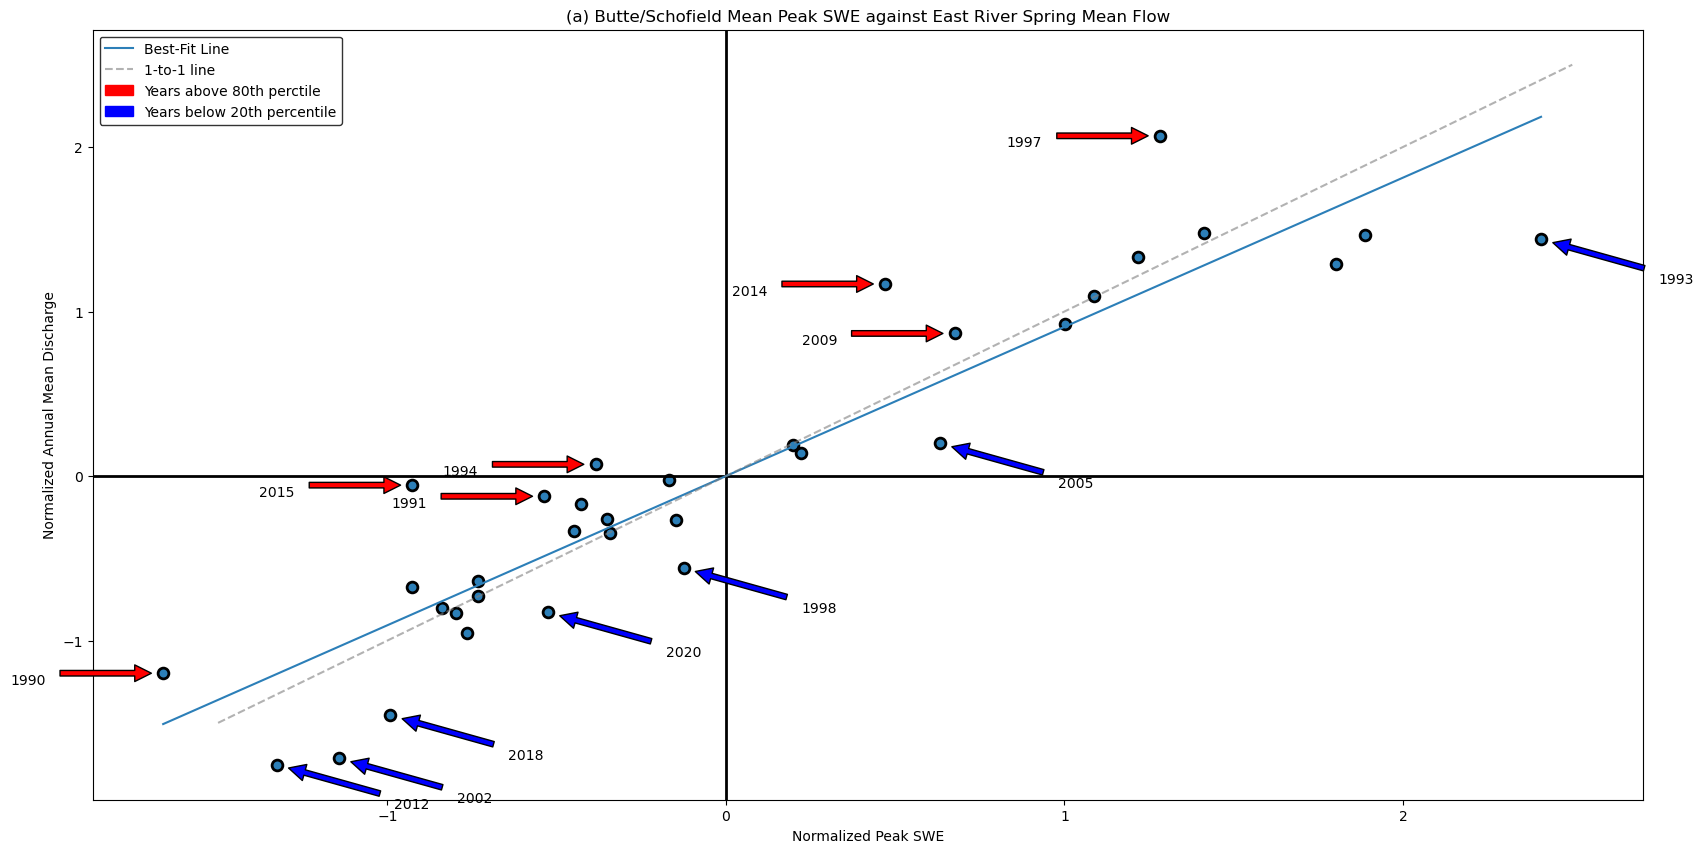

In [216]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
colors = ['#2c7fb8','#7fcdbb']
residual=residual.dropna()
idx_20th_percentile = (residual[residual < np.percentile(residual,20)].index).astype(int)
idx_80th_percentile = (residual[residual > np.percentile(residual,80)].index).astype(int)

ax.scatter(normalized_sntl_peak_swe, normalized_er_spring_q, color=colors[0], edgecolor='k', s=60, lw=2)
ax.axhline(0, color='k', lw=2)
ax.axvline(0, color='k', lw=2)
ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
ax.plot([-1.5,2.5],[-1.5,2.5], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
# ax.plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# ax.plot(p_x, p_y_upper, color=colors[1], ls='--', )
# ax.fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)


for i,idx in enumerate(idx_20th_percentile):

    ax.annotate(str(idx), 
                    (normalized_sntl_peak_swe.loc[idx], normalized_er_spring_q.loc[idx]),
                    (normalized_sntl_peak_swe.loc[idx]+0.4, normalized_er_spring_q.loc[idx]-0.2),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_80th_percentile):
    if idx == 2001:
        ax.annotate(str(idx), 
                (normalized_sntl_peak_swe.loc[idx], normalized_er_spring_q.loc[idx]),
                (normalized_sntl_peak_swe.loc[idx], normalized_er_spring_q.loc[idx]-0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        ax.annotate(str(idx), 
                (normalized_sntl_peak_swe.loc[idx], normalized_er_spring_q.loc[idx]),
                (normalized_sntl_peak_swe.loc[idx]-0.4, normalized_er_spring_q.loc[idx]),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

ax.arrow([],[],[],[], color='red', label='Years above 80th perctile',width=0.1)
ax.arrow([],[],[],[], color='blue', label='Years below 20th percentile',width=0.1)
ax.set_xlabel('Normalized Peak SWE')
ax.set_ylabel('Normalized Annual Mean Discharge')
ax.set_title('(a) Butte/Schofield Mean Peak SWE against East River Spring Mean Flow')
ax.legend(edgecolor='k', facecolor='white')

In [217]:
sorted_residual = residual.sort_values()

<AxesSubplot: >

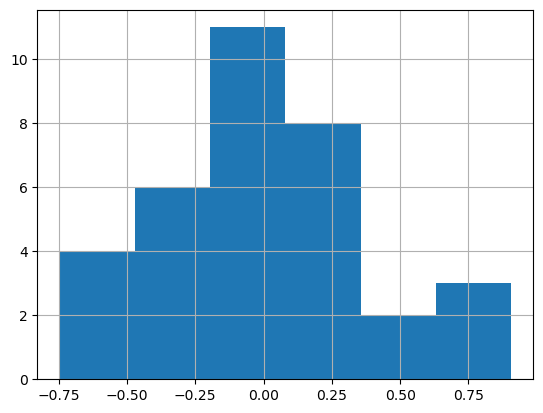

In [218]:
# plot resdual histogram
residual.hist(bins=round(1 + np.log2(len(residual)),0).astype(int))

### Calculate snow melt season length and sort by years

In [219]:
# melt season length dictionary
melt_season_length_dict = {}
snow_melt_date_dict = {}

# iterate through each year to calculate the WY melt season length
for year in np.unique(butte_uppertaylor_mean_ds_filtered.Date.dt.year.values):
    # if year not in [1986,2015]:
    if year not in [1986]:
        # Filter to each year
        tmp = butte_uppertaylor_mean_ds_filtered.where(butte_uppertaylor_mean_ds_filtered.Date.dt.year==year)['WTEQ'].dropna(dim='Date')
        # calculate maximum swe date
        peak_swe_date = tmp.idxmax().values
        # calculate peak swe value
        peak_swe = tmp.max()
        # calculate weekly rolling average
        weekly_rolling_mean = tmp.rolling(Date=7).mean()
        # first date where rolling weekly average is < 5% of Peak SWE  is considered snow melt date
        snow_melt_date = weekly_rolling_mean.where(weekly_rolling_mean==0).dropna(dim='Date')[0].Date.values
        # difference in time between peak and melt is snow melt season length
        melt_season_length = (snow_melt_date - peak_swe_date).astype('timedelta64[D]').astype(np.int32)
        # add to disctionary
        melt_season_length_dict[year] = melt_season_length
        snow_melt_date_dict[year] = pd.Timestamp(snow_melt_date).day_of_year
# create series of melt season length
melt_season_len_days = pd.Series(melt_season_length_dict.values(), index = melt_season_length_dict.keys(), name='melt_season_length')
sdd = pd.Series(snow_melt_date_dict.values(), index = snow_melt_date_dict.keys(), name='snow_dissapearance_date')
norm_melt_season_len = (melt_season_len_days - melt_season_len_days.mean())/melt_season_len_days.std()
norm_sdd = (sdd - sdd.mean())/sdd.std()

In [220]:
norm_melt_season_sorted = norm_melt_season_len.sort_values()

In [221]:
# Spearman rank coefficent for melt season length
stats.spearmanr(norm_melt_season_sorted.index, sorted_residual.index)

SignificanceResult(statistic=-0.03254392666157372, pvalue=0.8550237215883221)

In [222]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(norm_sdd.sort_values().index, sorted_residual.index)

SignificanceResult(statistic=0.01818181818181818, pvalue=0.9187089845919637)

(-1.2, 1.2)

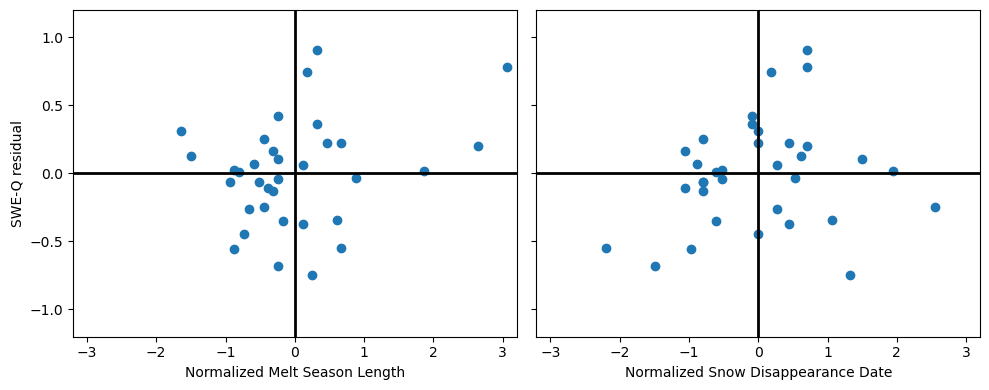

In [223]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10,4), sharey=True)

axs[0].scatter(norm_melt_season_len.values,residual.values)
axs[0].set_xlabel('Normalized Melt Season Length')
axs[0].set_ylabel('SWE-Q residual')
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].set_xlim(-3.2,3.2)
axs[0].set_ylim(-1.2,1.2)

axs[1].scatter(norm_sdd.values,residual.values)
axs[1].set_xlabel('Normalized Snow Disappearance Date')
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlim(-3.2,3.2)
axs[1].set_ylim(-1.2,1.2)

This does not really tell me much about the relationship between melt season length and the SWE-Q residual. A relationship does not seem to appear. Why might this be? It does not tell me anything about the timing of snow dissappearance. Perhaps snow disappearance date is more what I want. A shorter melt season would be expected to have to counteracting situations: 
1) signifies a warmer period during spring which could start up ET a bit earlier and remove more water, especially if the antecedent soil moisture was low
2) signifies rapid melt out, which may both saturate the soils and lead to overland flow, causing increased SWE-Q relationship

2015 had less than average snowfall, but greater than average streamflow, why might this be? Snowmelt season was rather drawn out and was well above average in length. Was it cold over this period? How much rain in spring was there? How strong was the monsoon? How saturated were soils in the fall?

# Remaining Things to Look at
- Signals for basin wide fall soil moisture
- Signals from fall, winter, and spring ET
- Signals from fall, winter, and spring SWE/Precip?
- Snow dissapearnce date

### Signals of Annual Precipitation

In [224]:
wrf_climatology_ds = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology_precip.nc')

In [225]:
wrf_climatology_precip = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True)['precip'].mean(dim=['south_north','west_east']).to_dataframe()
wrf_annual_precip = wrf_climatology_precip.groupby(wrf_climatology_precip['WY']).sum()
norm_wrf_annual_precip = (wrf_annual_precip-wrf_annual_precip.mean())/wrf_annual_precip.std()

sorted_annual_precip = norm_wrf_annual_precip.sort_values(by='precip')
sorted_annual_precip_top_5 = sorted_annual_precip[:5].index.values


### Signals of Seasonal Precipiation

In [226]:
# Import WRF standardized anomalies of precip
stand_anomalies_precip_df = pd.read_csv('/storage/dlhogan/sos/data/wrf_stand_anom_precip.csv')
stand_anomalies_precip_df = stand_anomalies_precip_df.set_index('XTIME')
stand_anomalies_precip_df.index = pd.to_datetime(stand_anomalies_precip_df.index)

In [227]:
def season_mean_df(df, calendar="standard", column=None):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    df['month_length'] = df.index.days_in_month
    # Calculate the weighted average
    return (df[column]* df['month_length']).resample('Q-DEC', convention='end').agg('sum') / df['month_length'].resample('Q-DEC', convention='end').agg('sum')

In [228]:
stand_anomalies_precip_seasonal_df  = season_mean_df(stand_anomalies_precip_df, column='precip').to_frame(name='precip')
norm_anomalies_precip_seasonal_df = stand_anomalies_precip_seasonal_df.groupby(stand_anomalies_precip_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std())
norm_anomalies_precip_seasonal_df.index = pd.to_datetime(norm_anomalies_precip_seasonal_df.index)
norm_anomalies_precip_seasonal_df['WY']=norm_anomalies_precip_seasonal_df.index.year.where(norm_anomalies_precip_seasonal_df.index.month<10,norm_anomalies_precip_seasonal_df.index.year+1)

In [229]:
sorted_summer_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==6].sort_values(by='precip')
sorted_summer_precip_top_5 = sorted_summer_precip[:5]['WY'].values

sorted_fall_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==9].sort_values(by='precip')
sorted_fall_precip_top_5 = sorted_fall_precip[:5]['WY'].values

sorted_winter_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==12].sort_values(by='precip')
sorted_winter_precip_top_5 = sorted_winter_precip[:5]['WY'].values

sorted_spring_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==3].sort_values(by='precip')
sorted_spring_precip_top_5 = sorted_spring_precip[:5]['WY'].values

In [230]:
# Spearman rank coefficent for seasonal ET
print(stats.spearmanr(sorted_fall_precip.WY, sorted_residual.index))
print(stats.spearmanr(sorted_spring_precip.WY, sorted_residual.index))
print(stats.spearmanr(sorted_winter_precip.WY, sorted_residual.index))
print(stats.spearmanr(sorted_summer_precip.WY, sorted_residual.index))

SignificanceResult(statistic=0.033766233766233764, pvalue=0.849639322364828)
SignificanceResult(statistic=-0.2611153552330023, pvalue=0.13579958882820425)
SignificanceResult(statistic=0.2137509549274255, pvalue=0.2248083582154243)
SignificanceResult(statistic=0.0004583651642475172, pvalue=0.9979472605715493)


### Signals of Upper East River Basin Wide Fall Soil Moisture

In [231]:
cbrfc_sm = rioxr.open_rasterio('/storage/dlhogan/sos/data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(upper_east_river_poly.crs, resampling=Resampling.cubic)
er_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(upper_east_river_poly.geometry)

In [232]:
# Normalized anomaly of basin mean fall soil moisture percent from normal
er_cbrfc_sm_rpj_basin_mean = er_cbrfc_sm_rpj.sel(year=slice(1986,2019)).mean(dim='x').mean(dim='y')
norm_er_cbrfc_rpj_basin_mean = (er_cbrfc_sm_rpj_basin_mean-er_cbrfc_sm_rpj_basin_mean.mean())/er_cbrfc_sm_rpj_basin_mean.std()

In [233]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].sort_values().index, sorted_residual.index)

SignificanceResult(statistic=-0.03712757830404889, pvalue=0.8348673196289484)

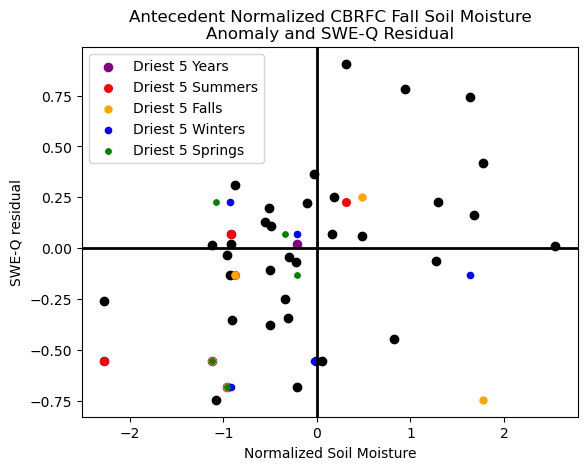

In [234]:
plt.scatter(norm_er_cbrfc_rpj_basin_mean,residual, color='k')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_annual_precip_top_5],residual.loc[sorted_annual_precip_top_5], color='purple',s=35,label='Driest 5 Years')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_summer_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='r', s=30, label='Driest 5 Summers')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_fall_precip_top_5],residual.loc[sorted_fall_precip_top_5], color='orange', s=25, label='Driest 5 Falls')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_winter_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='b', s=20, label='Driest 5 Winters')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_spring_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='g',s=15,label='Driest 5 Springs')


plt.title('Antecedent Normalized CBRFC Fall Soil Moisture\nAnomaly and SWE-Q Residual')
plt.ylabel('SWE-Q residual')
plt.xlabel('Normalized Soil Moisture')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)
plt.legend()

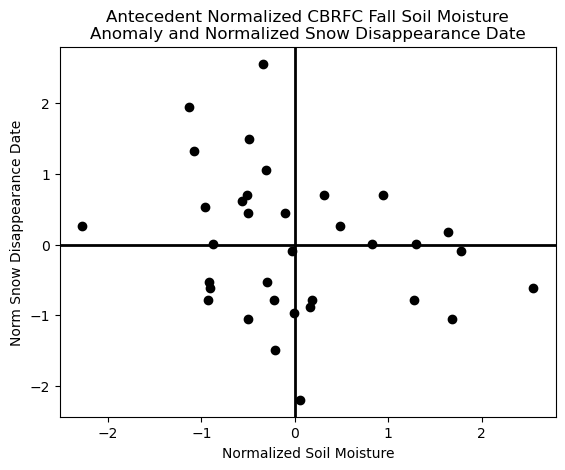

In [235]:
plt.scatter(norm_er_cbrfc_rpj_basin_mean,norm_sdd, color='k')

plt.title('Antecedent Normalized CBRFC Fall Soil Moisture\nAnomaly and Normalized Snow Disappearance Date')
plt.ylabel('Norm Snow Disappearance Date')
plt.xlabel('Normalized Soil Moisture')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)

### Signals of Annual ET

In [236]:
wrf_climatology_et = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True)['ET_rate'].mean(dim=['south_north','west_east']).to_dataframe()
wrf_annual_et = wrf_climatology_et.groupby(wrf_climatology_et['WY']).sum()
norm_wrf_annual_et = (wrf_annual_et-wrf_annual_et.mean())/wrf_annual_et.std()

sorted_annual_et = norm_wrf_annual_et.sort_values(by='ET_rate')
sorted_annual_et_top_5 = sorted_annual_et[-5:].index.values


In [237]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(sorted_annual_et.index, sorted_residual.index)

SignificanceResult(statistic=0.16333078686019864, pvalue=0.356022863255665)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


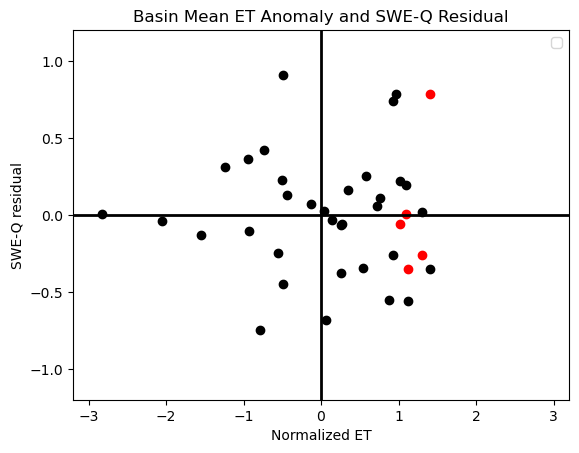

In [238]:
plt.scatter(sorted_annual_et,residual, color='k')
plt.scatter(sorted_annual_et.loc[sorted_annual_et_top_5],residual.loc[sorted_annual_et_top_5], color='r')

plt.title('Basin Mean ET Anomaly and SWE-Q Residual')
plt.ylabel('SWE-Q residual')
plt.xlabel('Normalized ET')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)
plt.xlim(-3.2, 3.2)
plt.ylim(-1.2,1.2)
plt.legend()

(-3.2, 3.2)

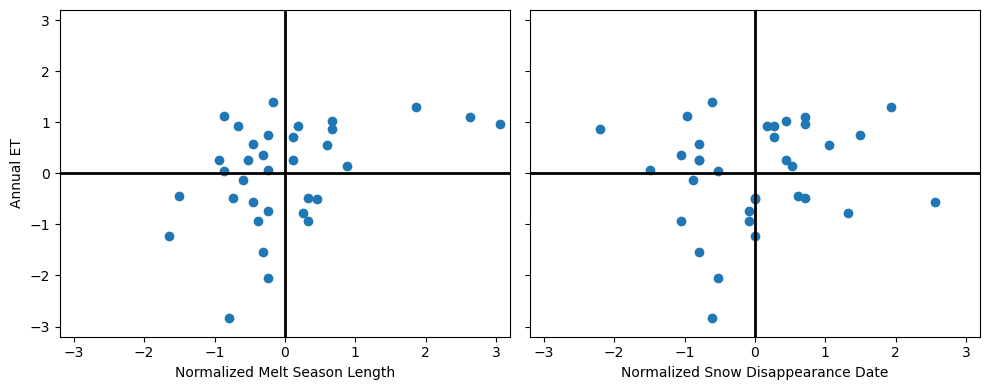

In [239]:

fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10,4), sharey=True)

axs[0].scatter(norm_melt_season_len.values,sorted_annual_et.values)
axs[0].set_xlabel('Normalized Melt Season Length')
axs[0].set_ylabel('Annual ET')
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].set_xlim(-3.2,3.2)
axs[0].set_ylim(-3.2,3.2)

axs[1].scatter(norm_sdd.values,sorted_annual_et.values)
axs[1].set_xlabel('Normalized Snow Disappearance Date')
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlim(-3.2,3.2)
axs[1].set_ylim(-3.2,3.2)

### Signals of Season Sublimation/Evaporation

In [240]:
stand_anomalies_et_df = pd.read_csv('/storage/dlhogan/sos/data/wrf_stand_anom_et.csv')
stand_anomalies_et_df = stand_anomalies_et_df.set_index('XTIME')
stand_anomalies_et_df.index = pd.to_datetime(stand_anomalies_et_df.index)

In [241]:
stand_anomalies_et_seasonal_df  = season_mean_df(stand_anomalies_et_df, column='ET_rate').to_frame(name='ET_rate')
norm_anomalies_et_seasonal_df = stand_anomalies_et_seasonal_df.groupby(stand_anomalies_et_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std())
norm_anomalies_et_seasonal_df.index = pd.to_datetime(norm_anomalies_et_seasonal_df.index)
norm_anomalies_et_seasonal_df['WY']=norm_anomalies_et_seasonal_df.index.year.where(norm_anomalies_et_seasonal_df.index.month<10,norm_anomalies_et_seasonal_df.index.year+1)

In [242]:
# Spearman rank coefficent for seasonal ET
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==9].sort_values(by='ET_rate').WY, sorted_residual.index))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==12].sort_values(by='ET_rate').WY, sorted_residual.index))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==3].sort_values(by='ET_rate').WY, sorted_residual.index))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==6].sort_values(by='ET_rate').WY, sorted_residual.index))

SignificanceResult(statistic=-0.09152024446142093, pvalue=0.606712450987037)
SignificanceResult(statistic=-0.14560733384262795, pvalue=0.4112678544527584)
SignificanceResult(statistic=0.05668449197860962, pvalue=0.7501681549385577)
SignificanceResult(statistic=0.07746371275783039, pvalue=0.6632376426417506)


Text(0, 0.5, 'Normalized Basin Mean ET')

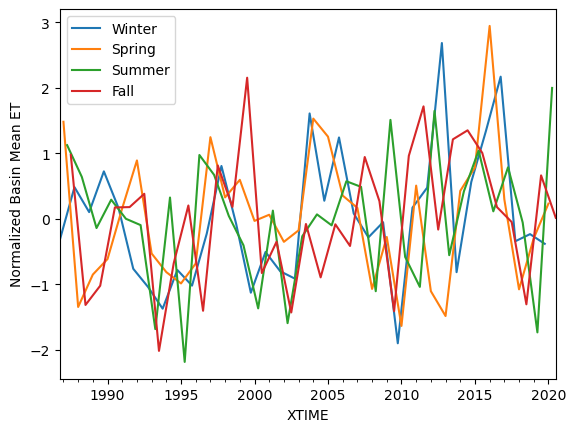

In [243]:
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==12]['ET_rate'].plot(label='Winter')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==3]['ET_rate'].plot(label='Spring')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==6]['ET_rate'].plot(label='Summer')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==9]['ET_rate'].plot(label='Fall')
plt.legend()
plt.ylabel('Normalized Basin Mean ET')

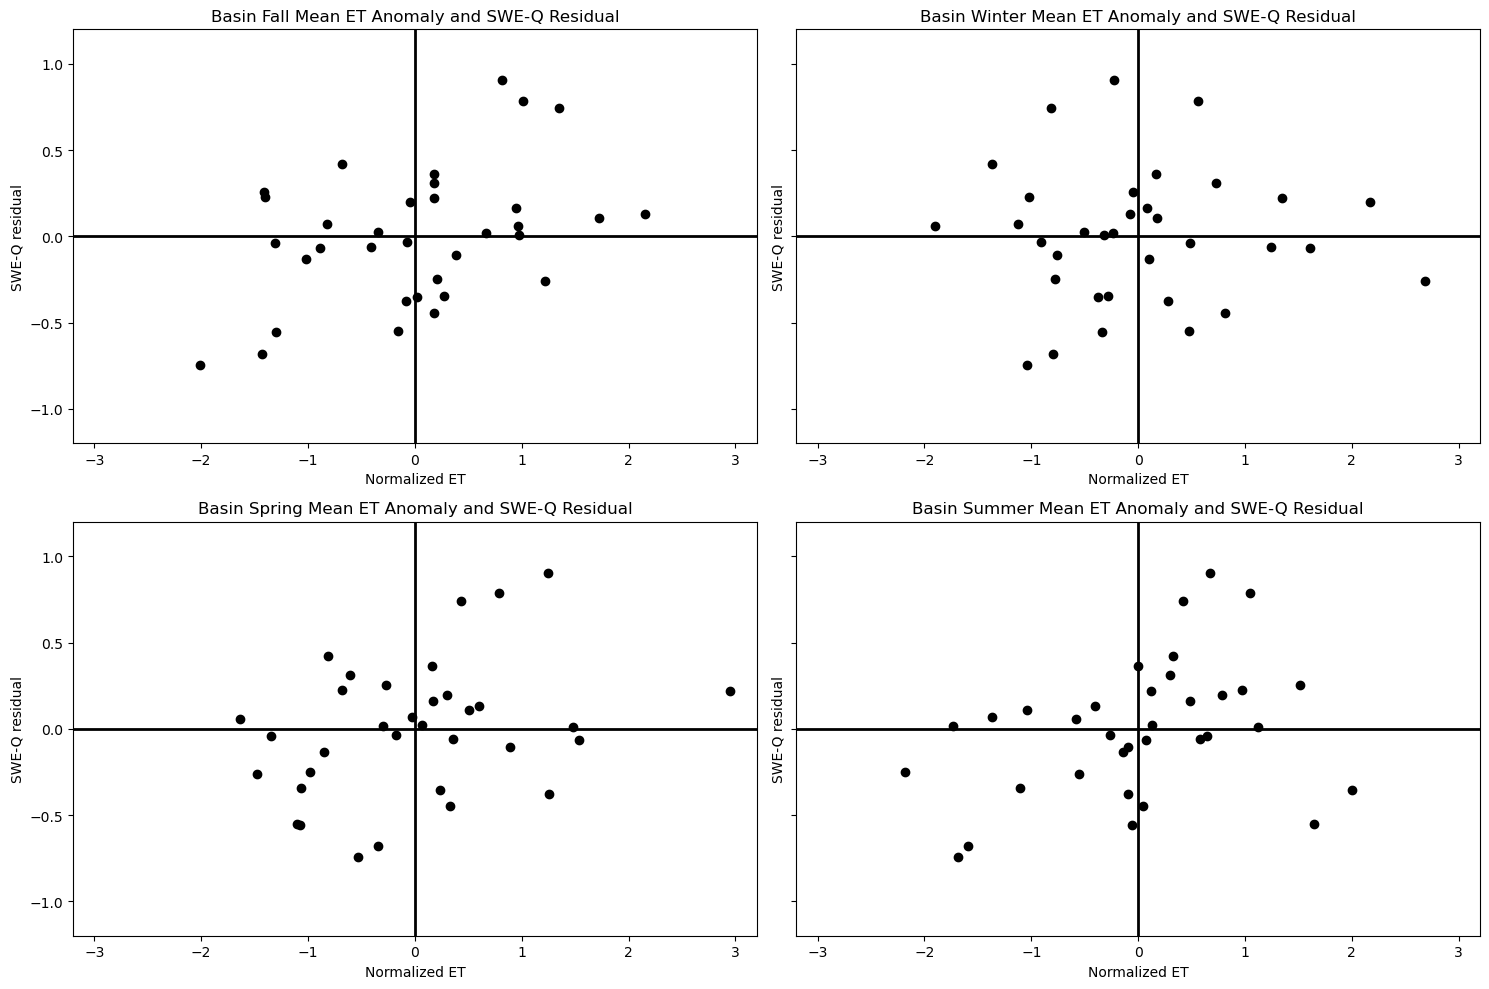

In [244]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(15,10))

axs = axs.ravel()
seasons = {
    'Fall':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==9]['ET_rate'],
    'Winter':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==12]['ET_rate'],
    'Spring':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==3]['ET_rate'],
    'Summer':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==6]['ET_rate']
}

for i,ax in enumerate(axs):
    ax.scatter(list(seasons.values())[i],residual, color='k')
    ax.set_title(f'Basin {list(seasons.keys())[i]} Mean ET Anomaly and SWE-Q Residual')
    ax.set_ylabel('SWE-Q residual')
    ax.set_xlabel(f'Normalized ET')
    ax.axhline(0, color='k', lw=2)
    ax.axvline(0, color='k', lw=2)
    ax.set_xlim(-3.2,3.2)
    ax.set_ylim(-1.2,1.2)

### Put the rankings side by side

In [251]:
# Annual ordered SWE-Q residual, Fall soil moisture, Winter ET, Annual ET, Winter Precip, Spring Precip
sorted_year_anomaly_df = pd.DataFrame(
    [
        sorted_residual.index,
        norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].sort_values().index,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==12].sort_values(by='ET_rate',ascending=False).WY,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==3].sort_values(by='ET_rate',ascending=False).WY,
        sorted_annual_et.index[::-1],
        sorted_spring_precip.WY,
        sorted_winter_precip.WY,
        sorted_fall_precip.WY,
        sorted_summer_precip.WY,
        norm_sdd.sort_values().index,
        melt_season_len_days.sort_values().index,
        melt_season_len_days.sort_values(ascending=False).index
    ],
).T

cols=['SWE-Q residual', "Fall soil moisture", "Winter ET", "Spring ET", "Annual ET", "Spring Precip", "Winter Precip", "Fall Precip", "Summer Precip", "SDD", "Melt Season (s-l)", "Melt Season (l-s)"]

sorted_year_anomaly_df = sorted_year_anomaly_df.rename(columns = dict(zip(sorted_year_anomaly_df.columns, cols)))
# sorted_year_anomaly_df = sorted_year_anomaly_df.set_index('SWE-Q residual')
sorted_year_anomaly_df.head(7)

,SWE-Q residual,Fall soil moisture,Winter ET,Spring ET,Annual ET,Spring Precip,Winter Precip,Fall Precip,Summer Precip,SDD,Melt Season (s-l),Melt Season (l-s)
0,1993.0,2012.0,2013.0,2016.0,2015.0,2002.0,2000.0,1993.0,2002.0,2012.0,1990.0,2015.0
1,2002.0,2018.0,2017.0,2004.0,2013.0,2018.0,1990.0,2009.0,2012.0,2002.0,1999.0,2017.0
2,2018.0,1992.0,2004.0,1987.0,2020.0,2001.0,2013.0,2018.0,1989.0,1992.0,2004.0,2019.0
3,2012.0,2002.0,2016.0,2005.0,1987.0,1994.0,2001.0,2002.0,2000.0,2007.0,2001.0,2003.0
4,1998.0,1988.0,2006.0,1997.0,2006.0,1992.0,1988.0,1989.0,1996.0,2018.0,2018.0,2016.0
5,2005.0,2000.0,1998.0,1992.0,2014.0,1999.0,2012.0,1988.0,2013.0,2000.0,1987.0,2012.0
6,2020.0,2019.0,1990.0,2015.0,2016.0,1998.0,1996.0,1996.0,1988.0,1989.0,1998.0,2008.0


Notes for the largest negative SWE-Q residual 
1) 1993 - Fall soil moisture anomaly and antecedent spring precip anomaly
2) 2005 - Spring ET anomaly

1) 2002 - Spring Precip anomaly, summmer precip anomaly, fall precip anomaly, early date of snow disappearance
2) 2018 - Spring & Winter & Fall Precip anomaly, results in fall soil moisute anomaly, early date of snow disappearance, short melt
3) 2012 - Winter and Summer Precip anomaly, early date of snow disappearance, long melt season
4) 1998 - winter ET anomaly, spring precip anomaly,  short melt season
5) 2020 - soil moisture anomaly in 2018 and 2019, annual ET anomaly

**Hypothesis (1) - Antecedent fall soil moisture signal leads to the immediate supply of water from snow in spring to replenish this resource, leaving this water in the root zone for plants.**
- Years that would fall in this category: 1993, 2020
- Does MERRA-2 also show this?

**Hypothesis (2) - Seasonal precipitation anomalies essentially do the same thing, but within a water year, especially if we have a dry winter, spring or fall, more of the melting snow will go towards the supply needed for plants, with snow disappearing earlier?**
- Years that would fall in this category: 2018, 2012, 2002
- Can I see this in the groundwater data for 2018 (does this year have our lowest groundwater levels?)

**Hypothesis (3) - ET anomalies during warmer winters/springs remove water from the snowpack that would otherwise flow into the river. Annual ET anomalies may do this year-round with warmer temperatures**
- Years that would fall in this category: 1998, 2005, 2020
- Do these years correlate with warmer than average winters/springs? Check out billy's climatology to see if this holds true

Can I get a signal for 2021 and estimate why we had missing water?
Can I test basin wide water balances with ET, SWE, Precip, Soil Moisture (Merra-2), and streamflow
Q = SWE + P - ET - ΔS